In [1]:
# pip install pandas
# pip install numpy
# pip install keras
# pip install tensorflow
# pip install sklearn
# pip install matplotlib
# pip install imblearn

In [2]:
import pandas as pd
import numpy as np
from keras.layers import Dense, Flatten
from keras.layers import Input
from keras.models import Model
import General.DL_read_data as read_data
import General.Run_models as run
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
from keras.layers import Dropout
from keras.layers.convolutional import MaxPooling1D, UpSampling1D
from keras.layers.convolutional import Conv1D
from sklearn.model_selection import train_test_split
import keras
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score
import General.write_results_csv as wr
import General.UTILS as utils
from keras.layers import BatchNormalization
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# from imblearn.under_sampling import RandomUnderSampler
# import time


2021-11-23 08:24:05.478205: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-23 08:24:05.478251: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


MAÑANA PUEDES HACER UN RESAMPLING DE LAS MUESTRAS PARA TENER MAS

##### Read Data

In [3]:
file_to_save = 'results/resultados.csv'
path = 'Data_to_work'

# read labeled dataset as pandas Dataframe
wisdm_df = pd.read_csv(path + '/WISDM.csv')
# Normalize the data
scaler = StandardScaler()
scaler.fit(wisdm_df[['x-axis', 'y-axis', 'z-axis']])
wisdm_df[['x-axis', 'y-axis', 'z-axis']] = scaler.transform(wisdm_df[['x-axis', 'y-axis', 'z-axis']])

In [4]:
# wisdm_df.groupby(wisdm_df['activity']).head()

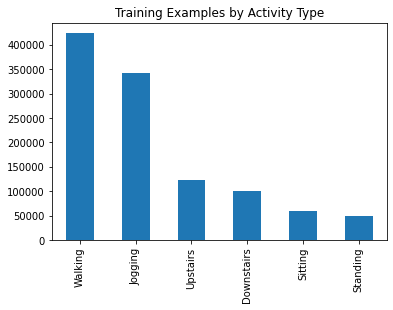

In [5]:
# Show how many training examples exist for each of the six activities
wisdm_df['activity'].value_counts().plot(kind='bar',
                                   title='Training Examples by Activity Type')
plt.show()

In [6]:
# read unlabeled data as panda Dataframe
usc_df = pd.read_csv(path + '/HUGADB_ordered_20hz.csv')
print(np.unique(usc_df['Activity']))

['DownStairs' 'Running' 'UpStairs' 'Walking' 'biclycling'
 'down in elevator' 'sit down' 'sitting' 'sitting in a car' 'standing'
 'standing up' 'up in elevator']


In [7]:
# Elimino las actividades que no me interesan
others = usc_df[usc_df['Activity'] == 'biclycling'].index
walk_left = usc_df[usc_df['Activity'] == 'down in elevator'].index
car = usc_df[usc_df['Activity'] == 'sitting in a car'].index
up = usc_df[usc_df['Activity'] == 'standing up'].index
down = usc_df[usc_df['Activity'] == 'sit down'].index
elevator = usc_df[usc_df['Activity'] == 'up in elevator'].index

usc_df.drop(others, inplace = True)
usc_df.drop(walk_left, inplace = True)
usc_df.drop(car, inplace = True)
usc_df.drop(up, inplace = True)
usc_df.drop(down, inplace = True)
usc_df.drop(elevator, inplace = True)
print(np.unique(usc_df['Activity']))

['DownStairs' 'Running' 'UpStairs' 'Walking' 'sitting' 'standing']


In [8]:
# Coloco las actividades en el mismo orden que WISDM
usc_df.loc[usc_df.Activity == "Walking", "ActivityEncoded"] = 5
usc_df.loc[usc_df['Activity'] == 'Running', 'ActivityEncoded'] = 1
usc_df.loc[usc_df['Activity'] == 'sitting', 'ActivityEncoded'] = 2
usc_df.loc[usc_df['Activity'] == 'standing', 'ActivityEncoded'] = 3
usc_df.loc[usc_df['Activity'] == 'DownStairs', 'ActivityEncoded'] = 0
usc_df.loc[usc_df['Activity'] == 'UpStairs', 'ActivityEncoded'] = 4
# usc_df.to_csv(path + '/USC-HAD_Ordered.csv')

In [9]:
# usc_df.groupby(usc_df['Activity']).head()

In [10]:
# Normalization based on training data
scaler_unlabeled = StandardScaler()
scaler_unlabeled.fit(usc_df[['x-axis', 'y-axis', 'z-axis']])
usc_df[['x-axis', 'y-axis', 'z-axis']] = scaler_unlabeled.transform(usc_df[['x-axis', 'y-axis', 'z-axis']])

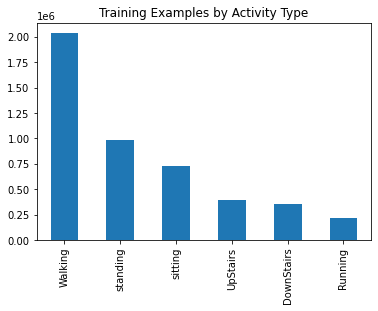

In [11]:
# Show how many training examples exist for each of the six activities
usc_df['Activity'].value_counts().plot(kind='bar',
                                   title='Training Examples by Activity Type')
plt.show()

##### Take percentage of Unlabeled data to train the model

Tenemos que tener en cuenta que en ese porcentaje de datos para entrenar el autoencoder, tenemos que coger la misma cantidad de clases. Es decir, en ese cacho de USC-HAD deben aparecer todas las actividades

#### Upsampling for class imbalance

In [12]:
usc_df =  utils.class_imbalance(usc_df)
wisdm_df = utils.class_imbalance(wisdm_df)

Class=1, total=349911, percentage=7.432
Class=2, total=214959, percentage=4.566
Class=3, total=725268, percentage=15.405
Class=4, total=985965, percentage=20.942
Class=5, total=394812, percentage=8.386
Class=6, total=2037219, percentage=43.270
Counter({5: 2037219, 3: 985965, 2: 725268, 4: 394812, 0: 349911, 1: 214959})
Class=1, total=2037219, percentage=16.667
Class=2, total=2037219, percentage=16.667
Class=3, total=2037219, percentage=16.667
Class=4, total=2037219, percentage=16.667
Class=5, total=2037219, percentage=16.667
Class=6, total=2037219, percentage=16.667
Counter({1: 2037219, 2: 2037219, 3: 2037219, 0: 2037219, 5: 2037219, 4: 2037219})
Class=1, total=100427, percentage=9.145
Class=2, total=342176, percentage=31.158
Class=3, total=59939, percentage=5.458
Class=4, total=48395, percentage=4.407
Class=5, total=122869, percentage=11.188
Class=6, total=424397, percentage=38.645
Counter({5: 424397, 1: 342176, 4: 122869, 0: 100427, 2: 59939, 3: 48395})
Class=1, total=424397, percent

##### Create Time Windows 3D Tensor

In [13]:
# generate time windows to execute the algorithm by batch
time_window = 200  # this dataset frequency 100hz 
overlap = 20  # 1 second of overlap
X_wisdm, Y_wisdm = read_data.create_windows_and_labels(time_window, overlap, wisdm_df)
X_usc, Y_usc = read_data.create_windows_and_labels(time_window, overlap, usc_df)

##### Defino AUTOENCODER 

In [14]:
def encoder_model(input_window):
    x = Conv1D(filters=64, kernel_size=3, activation='relu', padding="same")(input_window)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2, padding="same")(x)
    x = Conv1D(filters=64, kernel_size=3, activation='relu', padding="same")(x)
    x = Dropout(0.1)(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2, padding="same")(x)
    x = Conv1D(filters=64, kernel_size=3, activation='relu', padding="same")(x)
    x = Dropout(0.1)(x)
    x = BatchNormalization()(x)
    encoded = MaxPooling1D(2, padding="same")(x)
    return encoded


In [15]:
def decoder_model(encoded, features=3):
    x = Conv1D(filters=64, kernel_size=3, activation='relu', padding="same")(encoded)
    x = BatchNormalization()(x)
    x = UpSampling1D(2)(x)
    x = Conv1D(filters=64, kernel_size=3, activation='relu', padding="same")(x)
    x = Dropout(0.1)(x)
    x = BatchNormalization()(x)
    x = UpSampling1D(2)(x)
    x = Conv1D(filters=64, kernel_size=3, activation='relu', padding="same")(x)
    x = Dropout(0.1)(x)
    x = BatchNormalization()(x)
    x = UpSampling1D(2)(x)
    decoded = Conv1D(features, 3, activation='sigmoid', padding='same')(x)
    return decoded


In [16]:
def classifier_model(encoded):
    flat = Flatten()(encoded)
    drop = Dropout(0.5)(flat)
    mid = Dense(100, activation='relu')(drop)
    output = Dense(n_outputs, activation='softmax')(mid)
    return output

In [17]:
# Train Test Split with stratified number of classes
from sklearn.model_selection import StratifiedShuffleSplit

# We will train with 20% of WISDM our autoencoder and Classifier
X_train_wisdm, X_test_wisdm, Y_train_wisdm, Y_test_wisdm = train_test_split(X_wisdm, Y_wisdm, 
                                                                            test_size=0.5, random_state=42)

# We will train with 20% of WISDM our autoencoder and Classifier
X_train_usc, X_test_usc, Y_train_usc,Y_test_usc = train_test_split(X_usc, Y_usc, test_size=0.3, random_state=42)

##### Train Autoencoder with WISDM and percentage of USC-HAD

In [18]:
# Join train labeled data with unlabeled to train AutoEncoder
X_encoder = np.concatenate((X_train_wisdm, X_train_usc), axis=0)
timesteps, n_features, n_outputs = X_train_wisdm.shape[1], X_train_wisdm.shape[2], Y_train_wisdm.shape[1]
    
train_X_encoder, test_X_encoder, _, _ = train_test_split(X_encoder, X_encoder,
                                                             test_size=0.2)  # Split train test unlabeled
    
    
input_window = Input(shape=(train_X_encoder.shape[1], train_X_encoder.shape[2]))
    
# autoencoder joinning encoder and decoder
autoencoder = Model(input_window,decoder_model(encoder_model(input_window)))
# autoencoder.summary()
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    
# Train autoencoder with labeled + unlabeled samples
history = autoencoder.fit(train_X_encoder, train_X_encoder,epochs=30,
                            batch_size=512,
                            validation_data=(test_X_encoder, test_X_encoder),
                            callbacks=[
                            keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)])

2021-11-23 08:25:18.943107: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-23 08:25:18.943172: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-23 08:25:18.943214: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pruebas-antonio-2): /proc/driver/nvidia/version does not exist
2021-11-23 08:25:18.943585: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/30
768/768 [==============================] - 228s 292ms/step - loss: 1.0534 - val_loss: 0.9763
Epoch 2/30
768/768 [==============================] - 296s 385ms/step - loss: 0.9699 - val_loss: 0.9257
Epoch 3/30
768/768 [==============================] - 292s 380ms/step - loss: 0.9337 - val_loss: 0.8849
Epoch 4/30
768/768 [==============================] - 295s 384ms/step - loss: 0.9121 - val_loss: 0.8666
Epoch 5/30
768/768 [==============================] - 290s 377ms/step - loss: 0.8998 - val_loss: 0.8580
Epoch 6/30
768/768 [==============================] - 291s 379ms/step - loss: 0.8931 - val_loss: 0.8533
Epoch 7/30
768/768 [==============================] - 289s 376ms/step - loss: 0.8888 - val_loss: 0.8497
Epoch 8/30
768/768 [==============================] - 261s 340ms/step - loss: 0.8858 - val_loss: 0.8474
Epoch 9/30
768/768 [==============================] - 209s 272ms/step - loss: 0.8838 - val_loss: 0.8461
Epoch 10/30
768/768 [==============================] - 199s 260m

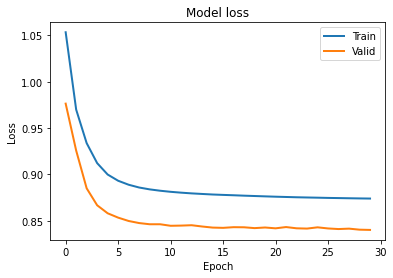

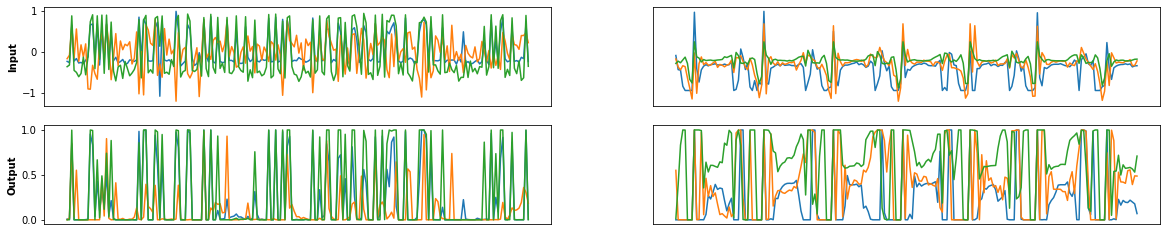

In [19]:
utils.loss_plot(history)
predict = autoencoder.predict(test_X_encoder)
utils.plot_examples(test_X_encoder, predict)

In [20]:
# Guardar el Modelo
autoencoder.save('autoencoder_hugadb.h5')

In [28]:
# Carga el modelo
autoencoder = keras.models.load_model('autoencoder_hugadb.h5')

In [29]:
encoded = encoder_model(input_window)  # Create encoder model again
    
full_model = Model(input_window, classifier_model(encoded))  # Create the final model Encoder + Dense Layers
    
# take enconder weights a set the weigths to my model classifier
for l1, l2 in zip(full_model.layers[0:12], autoencoder.layers[0:12]):
    l1.set_weights(l2.get_weights())
    
# avoid retrain encoder part again to keep the weights
for layer in full_model.layers[0:12]:
    layer.trainable = False
     
full_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# full_model.summary()
# full_model.save('results/best_models/AE_'+str(p)+'.h5')

Epoch 1/20
128/128 [==============================] - 11s 84ms/step - loss: 0.6910 - accuracy: 0.7301 - val_loss: 1.6653 - val_accuracy: 0.5063 - lr: 0.0010
Epoch 2/20
128/128 [==============================] - 8s 66ms/step - loss: 0.4361 - accuracy: 0.8255 - val_loss: 1.8098 - val_accuracy: 0.4962 - lr: 0.0010
Epoch 3/20
128/128 [==============================] - 8s 65ms/step - loss: 0.4015 - accuracy: 0.8426 - val_loss: 1.8450 - val_accuracy: 0.4776 - lr: 0.0010
Epoch 4/20
128/128 [==============================] - 9s 67ms/step - loss: 0.3719 - accuracy: 0.8530 - val_loss: 1.4860 - val_accuracy: 0.5214 - lr: 0.0010
Epoch 5/20
128/128 [==============================] - 9s 67ms/step - loss: 0.3553 - accuracy: 0.8565 - val_loss: 1.8103 - val_accuracy: 0.5073 - lr: 0.0010
Epoch 6/20
128/128 [==============================] - 8s 64ms/step - loss: 0.3408 - accuracy: 0.8640 - val_loss: 1.9464 - val_accuracy: 0.4671 - lr: 0.0010
Epoch 7/20
128/128 [==============================] - 8s 65ms/s

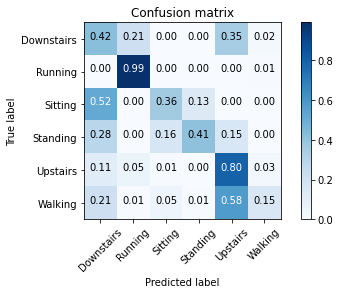

Normalized confusion matrix


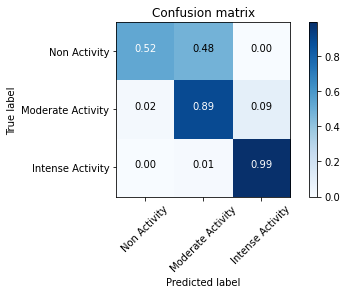

Epoch 1/20
128/128 [==============================] - 10s 78ms/step - loss: 0.3542 - accuracy: 0.8587 - val_loss: 1.5577 - val_accuracy: 0.5151 - lr: 1.0000e-05
Epoch 2/20
128/128 [==============================] - 10s 75ms/step - loss: 0.3482 - accuracy: 0.8622 - val_loss: 1.6191 - val_accuracy: 0.5081 - lr: 1.0000e-05
Epoch 3/20
128/128 [==============================] - 9s 71ms/step - loss: 0.3518 - accuracy: 0.8604 - val_loss: 1.6430 - val_accuracy: 0.5061 - lr: 1.0000e-05
Epoch 4/20
128/128 [==============================] - 9s 69ms/step - loss: 0.3489 - accuracy: 0.8597 - val_loss: 1.6579 - val_accuracy: 0.5073 - lr: 1.0000e-05
Epoch 5/20
128/128 [==============================] - 10s 75ms/step - loss: 0.3497 - accuracy: 0.8623 - val_loss: 1.6775 - val_accuracy: 0.5031 - lr: 1.0000e-05
Epoch 6/20
128/128 [==============================] - 10s 75ms/step - loss: 0.3510 - accuracy: 0.8604 - val_loss: 1.6890 - val_accuracy: 0.5009 - lr: 1.0000e-05
Epoch 7/20
128/128 [================

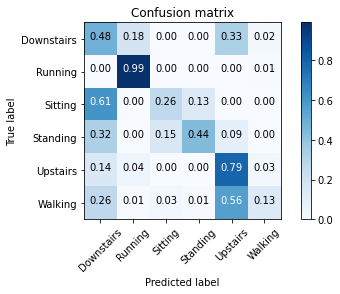

Normalized confusion matrix


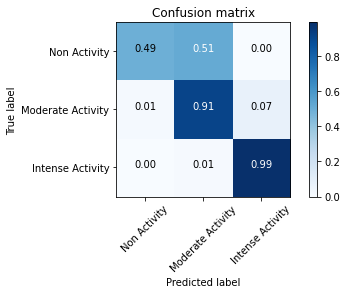

Epoch 1/20
128/128 [==============================] - 10s 75ms/step - loss: 0.3514 - accuracy: 0.8610 - val_loss: 1.5628 - val_accuracy: 0.5134 - lr: 1.0000e-07
Epoch 2/20
128/128 [==============================] - 8s 66ms/step - loss: 0.3532 - accuracy: 0.8601 - val_loss: 1.5636 - val_accuracy: 0.5133 - lr: 1.0000e-07
Epoch 3/20
128/128 [==============================] - 8s 66ms/step - loss: 0.3501 - accuracy: 0.8627 - val_loss: 1.5644 - val_accuracy: 0.5133 - lr: 1.0000e-07
Epoch 4/20
128/128 [==============================] - 9s 69ms/step - loss: 0.3519 - accuracy: 0.8602 - val_loss: 1.5654 - val_accuracy: 0.5133 - lr: 1.0000e-07
Epoch 5/20
128/128 [==============================] - 8s 64ms/step - loss: 0.3524 - accuracy: 0.8611 - val_loss: 1.5661 - val_accuracy: 0.5132 - lr: 1.0000e-07
Epoch 6/20
128/128 [==============================] - 9s 67ms/step - loss: 0.3502 - accuracy: 0.8614 - val_loss: 1.5669 - val_accuracy: 0.5130 - lr: 1.0000e-07
Epoch 7/20
128/128 [===================

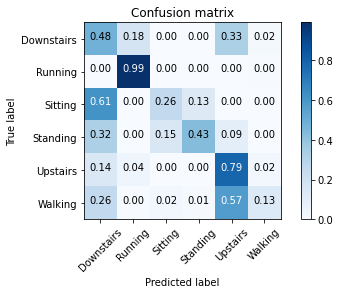

Normalized confusion matrix


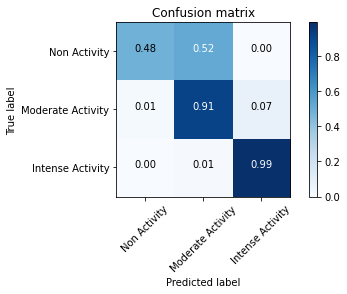

Epoch 1/20
128/128 [==============================] - 10s 76ms/step - loss: 0.3506 - accuracy: 0.8608 - val_loss: 1.5641 - val_accuracy: 0.5144 - lr: 1.0000e-08
Epoch 2/20
128/128 [==============================] - 9s 69ms/step - loss: 0.3524 - accuracy: 0.8597 - val_loss: 1.5642 - val_accuracy: 0.5144 - lr: 1.0000e-08
Epoch 3/20
128/128 [==============================] - 9s 74ms/step - loss: 0.3520 - accuracy: 0.8614 - val_loss: 1.5643 - val_accuracy: 0.5144 - lr: 1.0000e-08
Epoch 4/20
126/128 [============================>.] - ETA: 0s - loss: 0.3511 - accuracy: 0.8612

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Ahora estamos entranando con 80% de los datos
sss_usc = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=0)

for train_index_usc, test_index_usc in sss_usc.split(X_usc, Y_usc):
    X_train_usc, X_test_usc = X_usc[train_index_usc], X_usc[test_index_usc]
    Y_train_usc, Y_test_usc = Y_usc[train_index_usc], Y_usc[test_index_usc]

    check = ModelCheckpoint(filepath='hugadb.best.hdf5', verbose=0, 
                                   save_best_only=True)
    sch = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                  patience=5, min_lr=1e-8, verbose=0)
    early_st = EarlyStopping(monitor='val_loss', patience=10,
                                  verbose=0, restore_best_weights=True)

    full_model.fit(X_train_wisdm, Y_train_wisdm,epochs=20, batch_size=500, 
                   callbacks=[early_st,sch,check],validation_data=(X_test_usc, Y_test_usc))
    
     # Load best model
    full_model.load_weights('hugadb.best.hdf5')
    # METRICS
    # Evaluamos en el conjunto de Test de USC_HAD
    score = full_model.evaluate(X_test_usc, Y_test_usc)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    y_pred = full_model.predict(X_test_usc, verbose=1)  # Predict Results
    y_test_cv = Y_test_usc.argmax(axis=1)
    y_pred_cv = y_pred.argmax(axis=1)
    
    # get f1-score
    f1_macro = f1_score(y_test_cv, y_pred_cv, average='macro')
    f1_weighted = f1_score(y_test_cv, y_pred_cv, average='weighted')
    print('f1_macro:', f1_macro)
    print('f1_weighted:', f1_weighted)

    # get recall
    recall_macro = recall_score(y_test_cv, y_pred_cv, average='macro')
    recall_weighted = recall_score(y_test_cv, y_pred_cv, average='weighted')
    print('recall_macro:', recall_macro)
    print('recall_weighted:', recall_weighted)
    # run confusion matrix
    run.predict_confusion_matrix(y_pred, X_test_usc, Y_test_usc,"results/confusion_matrix.eps")
    create_confusion_matrix(y_pred, X_test_usc, Y_test_usc)

In [25]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import itertools
import numpy
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
   
    plt.figure()
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
def summary_labels(list_har):
    results = []
    for r in list_har:
        if r == 2 or r == 3:
             results.append(0) # Non Activity
        elif r == 0 or r == 4 or r ==5:
            results.append(1) #Moderate Activity
        elif r == 1:
            results.append(2) # Intense Activity
        else:
            print("Non acceptable activity")
    return results
        
def create_confusion_matrix(pred, xTest, yTest):
    
    class_pred=np.zeros(pred.shape)
    
    i=0
    for row in pred:
        class_pred[i, np.argsort(-row)[0]]=1.
        i+=1
    
    # NECESITAMOS AGRUPAR EN 3 CLASES
    # 0,4,5:Moderate 1:Intense 2,3: Non Activity
    test_data = summary_labels(yTest.argmax(axis=1))
    prediction = summary_labels(class_pred.argmax(axis=1))
  
    
    labels = ["Non Activity", "Moderate Activity","Intense Activity"]

    cm= confusion_matrix(numpy.array(test_data),numpy.array(prediction))
    plot_confusion_matrix(cm, labels)